# Load Relevant Packages and Data

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, RocCurveDisplay, PrecisionRecallDisplay,roc_auc_score, roc_curve, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
import os
from xgboost import XGBClassifier

# Defining Functions and Classes

Subclass of LogisticRegression that allows to set a different probability threshold for classification.

In [50]:
class LogisticRegressionCustom(LogisticRegression):
    def __init__(self, max_iter=100, class_weight=None, threshold=None):
        super().__init__(max_iter=max_iter, class_weight=class_weight)
        self.threshold = threshold
    
    def predict(self, X):
        if self.threshold != None:
            return (super().predict_proba(X)[:, 1] >= self.threshold).astype(int)
        else:
            return super().predict(X)

Function that takes as input the coefficients of any linear model and plots a bar plot of the magnitudes of the feature coefficients in decending order. It also color codes the features in the plot by the sign of their coefficient.

In [86]:
def plot_linear_feature_importances(coefficients, labels, number=20):
    indices_sorted = np.argsort(np.abs(coefficients))[:(-1) * number - 1:-1]
    top_coef = coefficients[indices_sorted]
    labels_sorted = labels[indices_sorted]
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = labels_sorted[neg_pos]
    pos_names = labels_sorted[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(labels_sorted)))
    ax.set_xticklabels(labels_sorted, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

Function that takes as input a list of feature importances and its labels and plots a bar plot.

In [116]:
def plot_feature_importances(importances, labels, number=20, title=None):
    num = number * (-1) - 1
    indices = importances.argsort()[:num:-1]
    plt.bar(x=labels[indices], height=importances[indices])
    plt.xticks(rotation=90)
    if isinstance(title, str):
        plt.title(title)
    elif isinstance(title, type(None)):
        plt.title('Feature Importances')
    else:
        print('Invalid dtype for parameter "title"')
    plt.show()

Function that takes results from a classification as input and to find the probability theshold at which a particular value for the true positive rate is achieved. Useful for choosing a different probability threshold when making classification preictions.

In [53]:
def find_threshold(y_true, y_proba, set_tpr, sample_weight=None):
    _, tpr_list, threshold_list = roc_curve(y_true, y_proba, sample_weight=sample_weight)
    for tpr, threshold in zip(tpr_list, threshold_list):
        if (tpr >= set_tpr):
            return tpr, threshold

Function that takes results of a classification and prints out the confussion matrix, classification report, and ROC curve. The output of the function are the scores from scikit-learn function `prfs_socres`, which outputs the precision, recall, f1 score, and support of the positive class. It also outputs a tuple containing displays for the confusion matrix, classification report, and ROC curve, which can later be used to make plots.

In [54]:
def my_scorer(y_test, y_pred, y_pred_proba=None, sample_weight=None, model_name=None, output=True):
    prfs_scores = precision_recall_fscore_support(y_test, y_pred, sample_weight=sample_weight)
    roc_auc_score_ = roc_auc_score(y_test, y_pred, sample_weight=sample_weight)
    scores = *prfs_scores, roc_auc_score_
    
    cf_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize = 'true')
    if output == True:
        if type(model_name) != type(None):
            plt.title(model_name)
        plt.show()
        print()
        
    if output == True:
        print(f'Classification Report: {model_name if type(model_name) != type(None) else ""}')
    class_report = classification_report(y_test, y_pred, sample_weight=sample_weight)
    if output == True:
        print(class_report)
        print()
    
    if type(y_pred_proba) != type(None):
        roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba, sample_weight=sample_weight)
        if output == True:
            if model_name != None:
                plt.title(model_name)
            plt.show()
    else:
        roc_display = None
        
    return scores, (cf_display, class_report, roc_display)

Function that takes an ml algorithm and a resampler as input. Applies train-test spit, resampling, and fitting. It then passes the prediction to the function `my_scorer`.

In [55]:
def my_pipeline(ml_algo, *data, model_name='Model', algo_params={}, resampler=None, split_params={}, output=True):
    if len(data) not in [2, 3]:
        print(f'Invalid length for "data": {len(data)}.')
        return
    
    results = {}
    
    split_result = train_test_split(*data, **split_params)
    if len(split_result) == 4:
        X_train, X_test, y_train, y_test = split_result
        w_train = None
        w_test = None
    elif len(split_result) == 6:
        X_train, X_test, y_train, y_test, w_train, w_test = split_result
    else:
        print('Invalid length for "split_result".')
        return
        
    if type(resampler) != type(None):
        X_train, y_train = resampler().fit_resample(X_train, y_train)
    
    model = ml_algo(**algo_params)
    model.fit(X_train, y_train, sample_weight=w_train)
    results['model_info'] = model_name, model
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba = None
        
    results['predictions_train'] = y_pred_train, y_pred_proba_train
    results['predictions'] =y_pred, y_pred_proba
    
    results['scores_train'], results['displays_train'] = my_scorer(y_train, y_pred_train, y_pred_proba_train, sample_weight=w_train, model_name=model_name + ' (train)', output=output)
    results['scores'], results['displays'] = my_scorer(y_test, y_pred, y_pred_proba, sample_weight=w_test, model_name=model_name, output=output)
    
    return results


Function that takes data as input, resamples it, and then applies the scikit-learn function `cross-validate`. It outputs the dictionary output by cross_validate as well as another dictionary with a summary of the results which will later be used to build a dataframe with a summary of results of various models.

In [56]:
def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={model_name + '__sample_weight':w}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

Function that takes data as input, resamples it, and then makes a `GridSearchCV` object. It outputs the dictionary from the `cv_results_` attribute of the fitted `GridSearchCV` object as well as another dictionary with a summary of the results which will later be used to build a dataframe with a summary of results of various models. 

In [57]:
def grid_cv_scorer(ml_algo, scoring, *data, model_name=None, param_grid={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo())])
    else:
        model = Pipeline([(model_name, ml_algo())])
        
    keys = [k for k in param_grid.keys()]
    for key in keys:
        param_grid[model_name + '__' + key] = param_grid.pop(key)
    
    clf = GridSearchCV(model, param_grid=param_grid, scoring=scoring, refit=False)
    clf.fit(X, y, CVSearch_Test__sample_weight=w)
    cv_scores = clf.cv_results_
    print('Printing cv_scores keys:')
    print(cv_scores.keys())
    print('Printing cv_scores:')
    print(cv_scores)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    #dict_scores['estimator'] = cv_scores['estimator']
    for score in scoring:
        #scores_ = cv_scores['test_' + score]
        mean_array = cv_scores['mean_test_' + score]
        std_array = cv_scores['std_test_' + score]
        
        cv_scores_summary[score]= dict(zip(['mean', 'std'], [mean_array, std_array]))
        
        if output == True:
            print(score + ' mean: ', mean_array)
            print(score + ' std: ', std_array)
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

Defining a list of "scorer" objects that can be used when the function `cross_validate`. For precision, recall, and f1, two scorers are made, one each for the positive and negative class. A scorer for the roc auc score is also made.

In [58]:
precision_score_pos = make_scorer(precision_score, pos_label=1)
precision_score_neg = make_scorer(precision_score, pos_label=0)

recall_score_pos = make_scorer(recall_score, pos_label=1)
recall_score_neg = make_scorer(recall_score, pos_label=0)

f1_score_pos = make_scorer(f1_score, pos_label=1)
f1_score_neg = make_scorer(f1_score, pos_label=0)

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Preparing Smaller Dataframe  
The dataframe that I previously cleaned contains hundreds of features. No prodecure for feature selection was carried out on the raw data so all of the features were kept. However, I would also like to build models with a much smaller dataframe that contains only the features pertaining to whether a particular health condition is present in the individual (e.g., whether the individual has diabetes, hypertension, etc). I would like to compare the performance on a baseline model when using both dataframes.

Loading raw dataframe

In [ ]:
path = '../Data/df_clean_null.pkl'
df = pd.read_pickle(path)

Choosing subset of features to include in the model

In [ ]:
feature_names = ['_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_ASTHMS1', '_DRDXAR1', '_RACEGR3', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_SMOKER3',\
    '_RFDRHV5', '_PACAT1', '_RFSEAT2', '_FLSHOT6', '_PNEUMO2', '_AIDTST3', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'DRADVISE']
target_name = ['_MICHD']
weights_name = ['_LLCPWT'] 

In [ ]:
df = df[feature_names + target_name + weights_name]
df

**Relabeling Data**

Relabeling data on some of the chosen features so that "1" means "yes" and "2" means "No". After this relabeling, all features that will be includen in the model will have the same meaning for the labels "1" and "2".

In [ ]:
for column in ['_RFHYPE5', '_RFCHOL', '_RFDRHV5']:
    df[column] = df[column].apply(lambda x: 1.0 if x == 2.0 else 2.0 if x == 1.0 else x)

For two of the features, null values represent survey respondents with age less than 65. I therefore rename the null entries to "65".

In [ ]:
for column in ['_FLSHOT6', '_PNEUMO2']:
    df[column] = df[column].cat.add_categories([65.0])
    df[column] = df[column].fillna(65.0)

For the following feature, I only wish the model to consider wheter the survey respondent has or has not been informed my a medical practitioner wheter he has diabetes or not. Therefore, all the categores which indicate that the survey respondent has diabetes will be relabeled to "1" and all the onces that indicate otherwise will be relabeled to "2". Categories "7" and "9" indicate missing entries, so those will not be changed.

In [ ]:
df['DIABETE3'] = df['DIABETE3'].map({1.0:1.0, 2.0:1.0, 3.0:2.0, 4.0:2.0, 7.0:7.0, 9.0:9.0}).astype('category')

For the case of the target, the negative class will be labeled "0" while the positive class will be labeled "1".

In [ ]:
df['_MICHD'] = df['_MICHD'].apply(lambda x: 0.0 if x == 2 else x)

**Imputing**  
Some columns will be dropped entirely. For categorical features, missing values will be given their own category. For continuous numerical features with long-tailed distributions, the missing values will be imputed with the mean. Finally, for continuous numerical features that are approximatedly Gaussian-distributed, the missing values will be imputed with the mean.

In [ ]:
def imputer(dataframe, category_value_tofill=None, columns_drop=None, columns_mode=None, columns_median=None):
    '''Imputes missing values to the input dataframe.
    
       Parameters
       ----------
       dataframe: Pandas dataframe
           dataframe with which to impute missing values.
       
       category_value_tofill: int, float, or string
           Value to used to fill missing values in categorical features.
       
       columns_drop: list-like
           List of columns to drop.
       
       columns_mode: list-like
           List of numeric columns to impute with the mode.
           
       columns_median: list-like
           List of numeric columns to impute with the mean.
    '''
    #Fill null values in categorical features with value_null
    if category_value_tofill != None:
        for column in dataframe.select_dtypes(include='category').columns:
            if any(dataframe[column].isnull()):
                dataframe[column] = dataframe[column].cat.add_categories([category_value_tofill])
                dataframe[column] = dataframe[column].fillna(value=category_value_tofill)
            
    #Droping columns, imputing with mode, and imputing with median.
    if columns_drop != None:
        dataframe = dataframe.drop(columns=columns_drop)
    if columns_mode != None:
        dataframe = dataframe.fillna(dataframe[columns_mode].mode().iloc[0, :])
    if columns_median != None:
        dataframe = dataframe.fillna(dataframe[columns_median].median())
    
    return dataframe

In [ ]:
df = imputer(df, 999.0)

**Translating Feature Names**  
The selected features to include in the model will be given more informative names.

In [ ]:
trans_list = ['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol', 'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat', 'Education_Level', 'Income_Level', \
    'Smoker_Status', 'Heavy_Drinker', 'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV', 'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX', \
        'Marital Status', 'Sodium', 'Heart_Disease', 'Sample_Weights']

In [ ]:
trans_dict = dict(zip(feature_names + target_name + weights_name, trans_list))
trans_dict

In [ ]:
df = df.rename(columns=trans_dict)
df

**Dropping the rows for which the target feature has a missing valule**

In [ ]:
df = df.drop(df[df[trans_dict[target_name[0]]] == 999.0].index)

**One-hot Encoding**

In [ ]:
cols_to_one_hot = [column for column in df.select_dtypes(include='category').columns if column not in ['Heart_Disease']]

column_trans = ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cols_to_one_hot)], remainder='passthrough')
column_trans.fit(df)

#List of feature names from the columns that where transformed and those that were not. It will be used to build the dataframe of the transfomred features in the next cell.
column_names_trans = np.concatenate([column_trans.named_transformers_['categorical'].get_feature_names_out(), np.array([trans_dict[target_name[0]], trans_dict[weights_name[0]]])])

In [ ]:
df = pd.DataFrame(column_trans.transform(df), columns=column_names_trans)
df

**Save the dataframe as a pickled file** 

In [ ]:
with open('../Data/modeling_df.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(trans_dict, f)

# Training Baseline Model Using Both Dataframes  
The baseline model that will be used to compare the performance when using both dataframes will be a logistic regression classifier with balanced class weights.

**Loading dataframe. Defining matrices for features, target, and weights.**

## Large Dataframe

**Loading Data**

In [ ]:
with open('../Data/preprocessed.pkl.zip', 'rb') as f:
    _ = pickle.load(f)
    col_names = pickle.load(f)
    X = pickle.load(f)
    y = pickle.load(f)
    cat_slice = pickle.load(f)
    skewed_slice = pickle.load(f)
    non_skewed_slice = pickle.load(f)

    X_train = pickle.load(f)
    X_test = pickle.load(f)
    y_train = pickle.load(f)
    y_test = pickle.load(f)    

**Training the Model**

In [ ]:
path = '../Data/first_log_model.pkl'
if not os.path.exists(path):
    logistic_regressor = LogisticRegression(max_iter=10000, class_weight='balanced')
    logistic_regressor.fit(X_train, y_train)
    with open(path, 'wb') as f:
        pickle.dump(logistic_regressor, f)
else:
    with open(path, 'rb') as f:
        logistic_regressor = pickle.load(f)

**Predictions**

In [ ]:
coef = logistic_regressor.coef_[0]
y_pred_train = logistic_regressor.predict(X_train)
y_proba_train = logistic_regressor.predict_proba(X_train)[:, 1]
y_pred = logistic_regressor.predict(X_test)
y_proba = logistic_regressor.predict_proba(X_test)[:, 1]

**Scoring**

Training Set

In [ ]:
_ = my_scorer(y_train, y_pred_train, y_proba_train, model_name='Logistic Regression, Large Dataframe, Training Set')

Test Set

In [ ]:
_ = my_scorer(y_test, y_pred, y_proba, model_name='Logistic Regression, Large Dataframe, Test Set')

## Small Dataframe

**Loading Data**

In [5]:
with open('../Data/modeling_df.pkl', 'rb') as f:
    df = pickle.load(f)
    
y = df['Heart_Disease']
w = df['Sample_Weights']
X = df.drop(columns=[y.name, w.name])

**Training the Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
logistic_regressor = LogisticRegressionCustom(max_iter=500, class_weight='balanced')
logistic_regressor.fit(X_train, y_train)

**Predictions**

In [ ]:
coef = logistic_regressor.coef_[0]
y_pred_train = logistic_regressor.predict(X_train)
y_proba_train = logistic_regressor.predict_proba(X_train)[:, 1]
y_pred = logistic_regressor.predict(X_test)
y_proba = logistic_regressor.predict_proba(X_test)[:, 1]

**Scoring**

Training Set

In [ ]:
_ = my_scorer(y_train, y_pred_train, y_proba_train, model_name='Logistic Regression, Small Dataframe, Training Set')

Test Set

In [ ]:
_ = my_scorer(y_test, y_pred, y_proba, model_name='Logistic Regression, Small Dataframe, Test Set')

## Comparison and Conclusionsa About Results From Both Dataframes

The results suggest that the performance of using the large dataframe is only marginally better than with the small dataframe (e.g., the roc auc score for the test set of the large dataframe is 0.86 while for the small dataframe is 0.84). Considering that the large dataframe has a significantlly larger amount of features, this suggest that the mayority of its features are unimportant. 

Considering that it takes longer to train a model using hundreds of features, that it is harder to interpret, and that the gains in its performance are small compared to the modoled that uses the smaller number of features, I have decided to build the rest of the models in this project using the smaller dataframe.

# Training Models

Main loop that will will build all the models. It will build different instances of Logistic Regression, Random Forest, and XGBoost Classifier models. For each of these three ml algorighms, different models will be built using different resampling techniques. For each of the models, cross-validation scores for precision, recall, f1, and roc auc will be evaluated. All results will be stored in a dictionary that will later be used to build a dataframe that summarizes the results.

In [ ]:
algo_list = {'Logistic Regression':LogisticRegressionCustom, 'Random Forest':RandomForestClassifier, 'XGBoost':XGBClassifier}
algo_params_list = [dict(max_iter=500), dict(n_estimators=100), {}]
imbalance_strategy_list = {'Basic':None, 'Class Weight':None, 'Random Oversampling':RandomOverSampler, 'SMOTE':SMOTE, 'Random Undersampling':RandomUnderSampler}
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}

cv_results = {}

for algo_name, algo_params in zip(algo_list, algo_params_list):
    for resampler_name, resampler in imbalance_strategy_list.items():
        if resampler_name == 'Basic':
            data = X, y, w
        else:
            data = X, y
        if (resampler_name == "Class Weight"):
            if algo_name == 'XGBoost':
                algo_params['scale_pos_weight'] = y[y == 0.0].shape[0] / y[y == 1].shape[0]
            else:
                algo_params['class_weight'] = 'balanced'
            
        cv_results.update(cv_scorer(algo_list[algo_name], scores, *data, model_name=algo_name+', '+resampler_name, algo_params=algo_params, resampler=resampler)[0])
        
        with open('../Data/modeling_results.pkl', 'wb') as f:
            pickle.dump(cv_results, f)


# Results

Function that takes the dictionary of cross-validation results and outputs a dataframe.

In [41]:
def results_to_df(cv_results):
    columns = []
    for score in cv_results[list(cv_results.keys())[0]].keys():
        if score != 'estimator':
            columns.append(score + '_mean')
            columns.append(score + '_std')
    
    data = []
    index = []
    for model_name in cv_results:
        index.append(model_name)
        row = []
        for score in cv_results[model_name]:
            if score != 'estimator':
                row.append(cv_results[model_name][score]['mean'])
                row.append(cv_results[model_name][score]['std'])
        data.append(row)
        
    return pd.DataFrame(data, index=index, columns=columns)

Dataframe summarizing the results of all the models

In [42]:
results_df = results_to_df(cv_results)
results_df

,precision_pos_mean,precision_pos_std,precision_neg_mean,precision_neg_std,recall_pos_mean,recall_pos_std,recall_neg_mean,recall_neg_std,f1_pos_mean,f1_pos_std,f1_neg_mean,f1_neg_std,roc_auc_mean,roc_auc_std
"Logistic Regression, Basic",0.527923,0.008592,0.920150,0.000730,0.112753,0.009544,0.990230,0.000873,0.185621,0.013114,0.953904,0.000173,0.843716,0.002932
"Logistic Regression, Class Weight",0.230812,0.004329,0.973399,0.001171,0.789687,0.012040,0.744919,0.009696,0.357149,0.004133,0.843927,0.005812,0.844623,0.003205
"Logistic Regression, Random Oversampling",0.230803,0.004462,0.973397,0.001256,0.789661,0.012845,0.744899,0.010114,0.357129,0.004219,0.843910,0.006047,0.844606,0.003248
"Logistic Regression, SMOTE",0.229910,0.002401,0.972232,0.001360,0.779592,0.013210,0.747002,0.007520,0.355054,0.001844,0.844837,0.004334,0.839771,0.003629
"Logistic Regression, Random Undersampling",0.230504,0.003929,0.973449,0.001094,0.790283,0.011201,0.744315,0.008913,0.356851,0.003744,0.843565,0.005342,0.844349,0.003153
"Random Forest, Basic",0.374947,0.013280,0.917658,0.000378,0.086480,0.004861,0.986033,0.000758,0.140497,0.006972,0.950618,0.000344,0.808868,0.002563
"Random Forest, Class Weight",0.300763,0.008545,0.918593,0.000360,0.107059,0.004754,0.975888,0.001014,0.157864,0.005834,0.946374,0.000440,0.800322,0.002287
"Random Forest, Random Oversampling",0.305289,0.002620,0.926621,0.000471,0.222452,0.006702,0.950963,0.001719,0.257302,0.004307,0.938633,0.000628,0.800728,0.002356
"Random Forest, SMOTE",0.367089,0.002649,0.921804,0.000318,0.145419,0.004700,0.975707,0.001034,0.208253,0.004435,0.947989,0.000325,0.809490,0.002348
"Random Forest, Random Undersampling",0.213221,0.003118,0.972713,0.001153,0.792302,0.011405,0.716702,0.008975,0.335972,0.003069,0.825273,0.005580,0.825270,0.002041


# Hyperparameter Tuning

## Choosing the Best Models for Hyperparameter Tuning  
I will use two metrics in order to choose a best model: the recall score of the positive class, and the roc auc score. 

The recall score was chosen because in a real-world-application scenario where you are trying to predict wheter a given individual has has heart diseasse, having a large false negative rate would be very problematic (i.e., telling a patient they don't have heart diseasse when in fact they do). The recall score of the positive class, also known as the true positive rate, is the probabilistic converse of the false negative rate. Therefore, this is the score that we want to maximize.

The roc auc score was chosen becasue it asseses the performance of the model "as a whole", independent of the chosen probability threshold for classification. 

In [44]:
results_df[results_df['roc_auc_mean'] == results_df['roc_auc_mean'].max()].index[0]

'Logistic Regression, Class Weight'

In [45]:
results_df[results_df['recall_pos_mean'] == results_df['recall_pos_mean'].max()].index[0]

'XGBoost, Random Undersampling'

## Hyperparameter Tuning

In [ ]:
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}
pipeline = Pipeline([('resampler', RandomUnderSampler()), ('XGBoost', XGBClassifier())])
param_grid={'XGBoost__eta':[0.3, 0.5, 0.7], 'XGBoost__max_depth':[1, 3, 6, 9], 'XGBoost__lambda':[0.2, 0.5, 1, 5, 10, 20]}
clf = GridSearchCV(pipeline, param_grid=param_grid, scoring=scores, refit=False)
clf.fit(X, y)

grid_cv_results = clf.cv_results_

with open('../Data/grid_cv_results_extra.pkl', 'rb') as f:
    grid_cv_results_extra = pickle.load(f)

**Finding Best Model from Hyperparameter Tuning Results**  
To evaluate the best model, we will use the recall score for the positive class and the roc auc score.

In [33]:
best_index_recall = np.where(grid_cv_results['rank_test_recall_pos'] == 1)[0][0]
best_index_roc_auc = np.where(grid_cv_results['rank_test_roc_auc'] == 1)[0][0]
print('Best parameters for recall:', grid_cv_results['params'][best_index_recall])
print('Recall score for best parameters:', grid_cv_results['mean_test_recall_pos'][best_index_recall])
print()
print('Best parameters for roc auc:', grid_cv_results['params'][best_index_roc_auc])
print('Roc auc score for best parameters:', grid_cv_results['mean_test_roc_auc'][best_index_roc_auc])

Best parameters for recall: {'XGBoost__eta': 0.3, 'XGBoost__lambda': 0.2, 'XGBoost__max_depth': 3}
Recall score for best parameters: 0.8135009476404569

Best parameters for roc auc: {'XGBoost__eta': 0.3, 'XGBoost__lambda': 10, 'XGBoost__max_depth': 3}
Roc auc score for best parameters: 0.8463194291528635


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
best_model = Pipeline([('resampler', RandomUnderSampler()), ('XGBoost', XGBClassifier(max_depth=3, eta=0.3, reg_lambda=10))])
best_model.fit(X_train, y_train)

with open('../Data/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

/home/hiram_g_menendez/Springboard/.conda/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hiram_g_menendez/Springboard/.conda/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:45:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
with open('../Data/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [48]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.8477845107352647

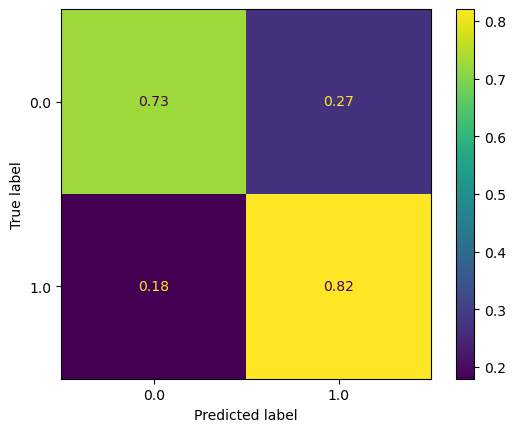


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.83    119665
         1.0       0.23      0.82      0.35     11590

    accuracy                           0.73    131255
   macro avg       0.60      0.77      0.59    131255
weighted avg       0.91      0.73      0.79    131255




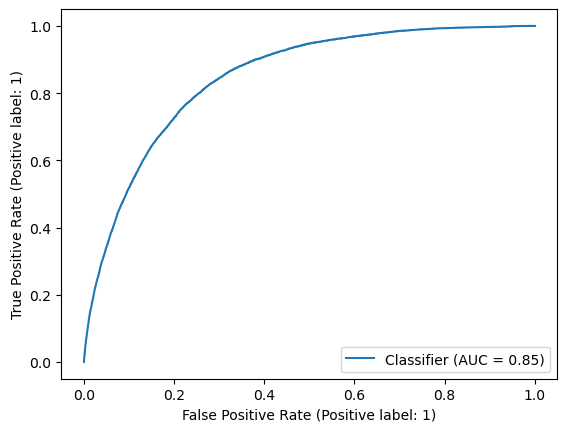

((array([0.97663184, 0.2251154 ]),
  array([0.72644466, 0.82053494]),
  array([0.83316161, 0.35330176]),
  array([119665,  11590]),
  0.7734898009603817),
 (<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f1cb0dff040>,
  '              precision    recall  f1-score   support\n\n         0.0       0.98      0.73      0.83    119665\n         1.0       0.23      0.82      0.35     11590\n\n    accuracy                           0.73    131255\n   macro avg       0.60      0.77      0.59    131255\nweighted avg       0.91      0.73      0.79    131255\n',
  <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f1ca768b1c0>))

In [59]:
my_scorer(y_test, best_model.predict(X_test), best_model.predict_proba(X_test)[:, 1])

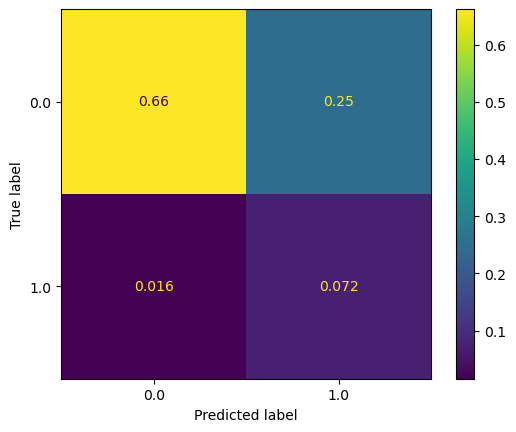

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test), normalize='all')
plt.show()

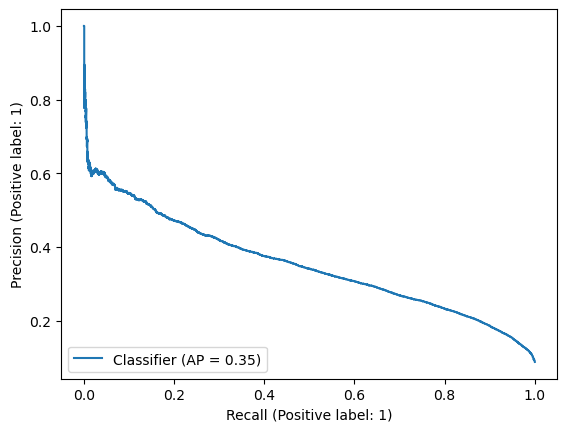

In [77]:
PrecisionRecallDisplay.from_predictions(y_test, best_model.predict_proba(X_test)[:, 1])
plt.show()

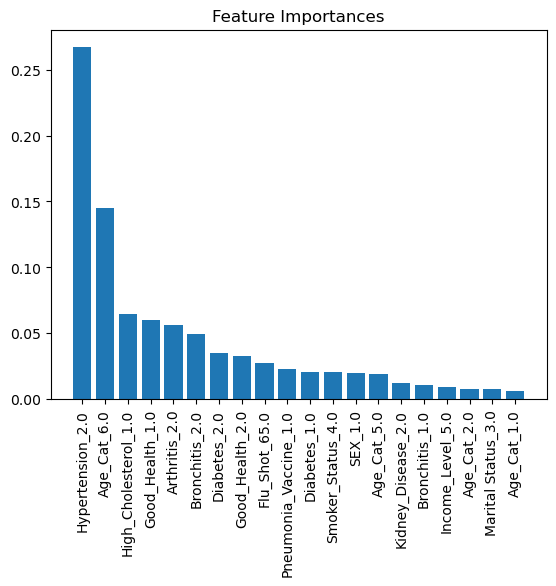

In [118]:
plot_feature_importances(best_model.named_steps['XGBoost'].feature_importances_, X.columns)

In [43]:
with open('../Data/modeling_results.pkl', 'wb') as f:
    pickle.dump(2, f)
    pickle.dump(cv_results, f)
    pickle.dump(grid_cv_results, f)

In [ ]:
with open('../Data/modeling_results.pkl', 'rb') as f:
    n = pickle.load(f)
    cv_results = pickle.load(f)
    grid_cv_results = pickle.load(f)